In [5]:
import os.path as op 
import xarray as xr 
import numpy as np 
from run_projection_test import SUBIDS, loadnii, loadfunc, OUTROOT, EXPERIMENTS, SIGNALS, INROOT
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from scipy import stats
import toblerone

cmap = np.array(plt.get_cmap('tab20').colors)
METHODS = ['tob', 'wb', 
           #'tob_edge', 'wb_edge', 
           'tob_sp', 'wb_sp']
METHOD_title = dict(zip(METHODS, ["Tob.", "RC", 
                                  #"Tob. edge", "RC edge", 
                                  "Tob-lsQR", "RC-lsQR"]))
METHOD_FLTR = [True, True, False, False, True, True]
METRIC = ['rms', 'max', 'min']
MASKED_RMS = lambda a,b,mask: np.sqrt(((a[mask] - b[mask])**2).mean())
SIGNAL_title = dict(zip(SIGNALS, ['uniform signal', 'sinusoid signal',]))
EXPERIMENT_title = dict(zip(EXPERIMENTS, ['Surface projection', 'Hybrid projection']))

def x_array(*args, **kwargs):
    if ('dims' not in kwargs) and ('coords' in kwargs): 
        kwargs['dims'] = kwargs['coords'].keys()
    a = xr.DataArray(*args, **kwargs)
    a[...] = 0 
    return a 

FileNotFoundError: No such file or no access: '/mnt/hgfs/Data/thesis_data/tob_projection/projected_output/ref_3.0.nii.gz'

In [2]:
def calc_tpr(truth, test, beta):
    inds = (truth > 0)
    tp = (test[inds] >= beta).sum()
    fn = (test[inds] < beta).sum()
    return tp / (tp + fn)

def calc_fpr(truth, test, beta):
    inds = (truth > 0)
    fp = (test[~inds] >= beta).sum()
    tn = (test[~inds] < beta).sum()
    return fp / (fp + tn)

In [3]:
def calc_nth_neighbours(for_surf, of_set, n=1, flat=False):
    """
    Does not include the original input the output set
    """
    neighbours = []
    old_n = for_surf.tris[np.isin(for_surf.tris, of_set).any(1),:].flatten()
    old_n = set(old_n) - set(of_set)
    neighbours.append(list(old_n))
    for order in range(n-1):
        new_n = for_surf.tris[np.isin(for_surf.tris, list(old_n)).any(1),:].flatten()
        update = (set(new_n) - set(old_n)) - set(of_set)
        neighbours.append(list(update))
        old_n = new_n 
        
    if flat: 
        neighbours = list(np.concatenate(neighbours))
    return neighbours 

In [4]:
N_SUBS = 45
BETA = np.linspace(0,1,200)

tpr = x_array(coords={'sub': range(N_SUBS), 'meth': ['tob', 'wb'], 
                              'space': ['vol', 'surf'], 'beta': range(BETA.size)})
fpr = x_array(coords={'sub': range(N_SUBS), 'meth': ['tob', 'wb'], 
                              'space': ['vol', 'surf'], 'beta': range(BETA.size)})

for idx,sub in enumerate(SUBIDS()[:N_SUBS]):

    sd = op.join(OUTROOT, 'naive', sub)
    struth = loadfunc(op.join(sd, 'activation.func.gii'))
    activated = np.flatnonzero(struth)
    surf = op.join(INROOT, sub, 'T1w', 'fsaverage_LR32k', f'{sub}.L.white.32k_fs_LR.surf.gii')
    surf = toblerone.Surface(surf)
    
    unactivated = np.random.choice(calc_nth_neighbours(surf, activated, 4, True), 
                                   size=activated.size, replace=False)
    struth_reduced = np.concatenate((struth[activated], struth[unactivated]))
    
    
    for meth in ['tob','wb']:
        stest = loadfunc(op.join(sd, '%s_activation.func.gii' % meth))
        stest_reduced = np.concatenate((stest[activated], stest[unactivated]))

        for bidx,b in enumerate(BETA): 
            tpr.loc[idx,meth,'surf',bidx] = calc_tpr(struth_reduced, stest_reduced / stest.max(), b)
            fpr.loc[idx,meth,'surf',bidx] = calc_fpr(struth_reduced, stest_reduced / stest.max(), b)


NameError: name 'x_array' is not defined

In [5]:
N_SUBS = 45
vsv = x_array(coords={'experiment': EXPERIMENTS, 'sub': range(N_SUBS),
                      'signal': SIGNALS, 'meth': METHODS, 'metric': METRIC})
svs = x_array(coords={'experiment': EXPERIMENTS, 'sub': range(N_SUBS), 
                      'signal': SIGNALS, 'meth': METHODS, 'metric': METRIC})

activations = x_array(coords={'sub': range(N_SUBS), 'meth': ['tob', 'wb'], 
                              'space': ['vol', 'surf'], 'metric': ['max', 'count']})

for exp in EXPERIMENTS:
    for idx,sub in enumerate(SUBIDS()[:N_SUBS]):

        sd = op.join(OUTROOT, 'naive', sub)
        struth = loadfunc(op.join(sd, 'activation.func.gii'))
        count = (struth > 0.1).sum()
        for meth in ['tob', 'wb']:
            vol = loadnii(op.join(sd, '%s_activation.nii.gz' % meth))
            surf = loadfunc(op.join(sd, '%s_activation.func.gii' % meth))
            activations.loc[idx,meth,'vol','max'] = vol.max()
            activations.loc[idx,meth,'surf','max'] = surf.max()
            activations.loc[idx,meth,'surf','count'] = (surf > 0.1).sum() / count        
        
        for signal in SIGNALS: 
            sd = op.join(OUTROOT, exp, sub)
            vtruth = loadnii(op.join(sd, '%s.nii.gz' % signal)) 
            if exp == 'wm_cbf':
                vtruth += loadnii(op.join(sd, 'wm_%s.nii.gz' % signal)) 
            mask = (vtruth > 0)
            struth = loadfunc(op.join(sd, '%s.func.gii' % signal))
            smask = loadfunc(op.join(sd, 'smask.func.gii')).astype(np.bool)
            
            for meth in METHODS: 
                try: 
                    path = op.join(sd, '%s_v2n2v_%s.nii.gz' % (signal,meth))
                    comp = loadnii(path)
                    maxidx = np.argmax(vtruth[mask])
                    vsv.loc[exp,idx,signal,meth,'rms'] = MASKED_RMS(vtruth, comp, mask) / vtruth[mask][maxidx]
                    vsv.loc[exp,idx,signal,meth,'max'] = 100 * (comp[mask][maxidx] / vtruth[mask][maxidx])
                    vsv.loc[exp,idx,signal,meth,'min'] = comp[mask].min()
                except Exception as e:
                    print(e)
 

                try: 
                    path = op.join(sd, '%s_n2v2n_%s.func.gii' % (signal,meth))
                    comp = loadfunc(path)
                    comp = comp[:struth.size]
                    maxidx = np.argmax(struth[smask])
                    svs.loc[exp,idx,signal,meth,'rms'] = MASKED_RMS(struth, comp, smask) / struth[smask][maxidx]
                    svs.loc[exp,idx,signal,meth,'max'] = 100 * (comp[smask][maxidx] / struth[smask][maxidx])
                    svs.loc[exp,idx,signal,meth,'min'] = comp[smask].min()
                except Exception as e:
                    print(e)


In [6]:
tob = []
wb = [] 
for s in range(N_SUBS):
    t = tpr.loc[s,'tob', 'surf', :]
    f = fpr.loc[s,'tob', 'surf', :]
    tob.append(np.trapz(t[::-1], f[::-1]))
    t = tpr.loc[s,'wb', 'surf', :]
    f = fpr.loc[s,'wb', 'surf', :]
    wb.append(np.trapz(t[::-1], f[::-1]))
tob = np.array(tob)
wb = np.array(wb)

In [7]:
def plot_format_violins(ax, data):
    violins = ax.violinplot(data.T)
    for c,v in zip([0,2,1,3], violins['bodies']): 
        v.set_facecolor(cmap[c,:])
    ax.set_xticks(range(1,5))
    ax.set_xticklabels(METHOD_title.values(), rotation=45)
    ax.plot([0,5], [0,0], 'k--', linewidth=0.5)
    ax.set_xlim(0.5,4.5)
    
def plot_ttest(ax, d1, d2):
    y1 = d1.max()
    y2 = d2.max()
    ymax = max([y1,y2])
    h = 0.1 * ymax
    ax.plot([1,1,2,2], [y1+h/2,ymax+h,ymax+h,y2+h/2], c='k', lw=0.5)
    p = stats.ttest_ind(d1, d2, equal_var=False).pvalue
    ceil_power = np.ceil(np.log10(p))
    if ceil_power <= -2: 
        ax.text(1.5, ymax+h, "*" % ceil_power % p, ha='center', va='bottom') 
#     else: 
#         ax.text(1.5, ymax+h, f"{p:.2f}", ha='center', va='bottom') 
        
YMIN = -10

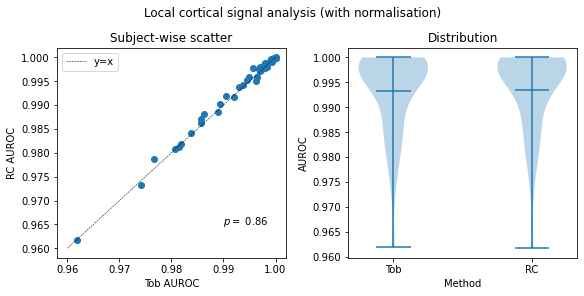

In [8]:
fig, axes = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
ttest = stats.ttest_ind(tob, wb, equal_var=False)
fig.suptitle('Local cortical signal analysis (with normalisation)')
ax = axes[0]
ax.scatter(tob,wb)
ax.plot([0.96,1], [0.96,1.0], 'k--', label='y=x', linewidth=0.5)
ax.set_title('Subject-wise scatter')
ax.legend()
ax.set_xlabel('Tob AUROC')
ax.set_ylabel('RC AUROC')
ax.text(0.99, 0.965, r'$p =$ %.2f' % ttest.pvalue)

ax = axes[1]
ax.violinplot([tob, wb], showmeans=True)
ax.set_title('Distribution')
ax.set_ylabel('AUROC')
ax.set_xticks([1,2])
ax.set_xticklabels(['Tob','RC'])
ax.set_xlabel('Method')
plt.savefig('figures/auroc.png', bbox_inches='tight', dpi=250)
plt.show()

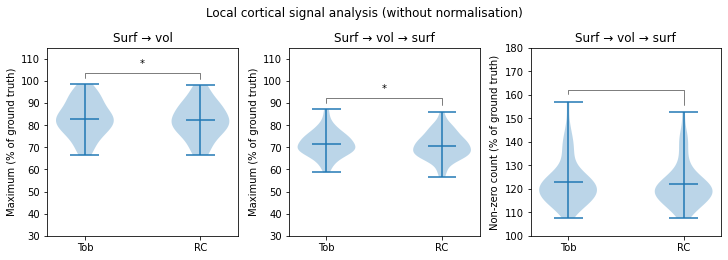

In [9]:
fig, axes = plt.subplots(1, 3, constrained_layout=True, figsize=(10,3.5))

for idx,(ax,title) in enumerate(zip(axes, ['Surf \u2192 vol', 'Surf \u2192 vol \u2192 surf'])):

    data = 100 * activations[:,:,idx,0].T
    ax.violinplot(data.T, showmeans=True)
    ax.set_xticks([1,2])
    ax.set_xticklabels(['Tob', 'RC'])
    ax.set_title(title)
    ax.set_ylim(30,115)
    ax.set_ylabel("Maximum (% of ground truth)")
    
    y1 = data[0,:].max() + 3
    y2 = data[1,:].max() + 3
    ymax = max([y1,y2])
    h = 2
    ax.plot([1,1,2,2], [y1,ymax+h,ymax+h,y2], c='k', lw=0.5)
    p = stats.ttest_rel(*data).pvalue
    ceil_power = np.ceil(np.log10(p))
    if ceil_power <= -2: 
        ax.text(1.5, ymax + 2 + h, "*" % ceil_power % p, ha='center', va='bottom')

ax = axes[2]
data = 100 * activations[:,:,1,1].T
ax.violinplot(data.T, showmeans=True)
ax.set_xticks([1,2])
ax.set_xticklabels(['Tob', 'RC'])
ax.set_title("Surf \u2192 vol \u2192 surf")
ax.set_ylabel("Non-zero count (% of ground truth)")
ax.set_ylim(100, 180)

y1 = data[0,:].max() + 3
y2 = data[1,:].max() + 3
ymax = max([y1,y2])
h = 2
ax.plot([1,1,2,2], [y1,ymax+h,ymax+h,y2], c='k', lw=0.5)
p = stats.ttest_ind(*data, equal_var=True).pvalue
ceil_power = np.ceil(np.log10(p))
if ceil_power <= -2: 
    ax.text(1.5, ymax+ 2 +h, "*" % ceil_power % p, ha='center', va='bottom')

fig.suptitle('Local cortical signal analysis (without normalisation)')
plt.savefig('figures/activation_results.png', dpi=250)
plt.show()

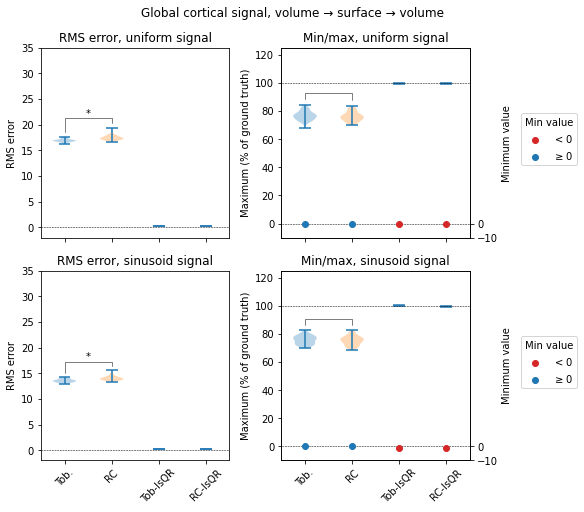

In [10]:
fig, axes = plt.subplots(len(EXPERIMENTS), 2, sharex=True, constrained_layout=True, figsize=(8,7))
for sigidx,sig in enumerate(SIGNALS):
        
        ax = axes[sigidx,0]
        data = 100 * vsv.loc['naive',:,sig,:,'rms'].T
        ax.set_title('%s, %s' % ('RMS error', SIGNAL_title[sig]))    
        plot_format_violins(ax, data)
        ax.set_ylim(-2, 35)
        ax.set_ylabel("RMS error")
        plot_ttest(ax, *data[:2])
        
        ax = axes[sigidx,1]
        data = vsv.loc['naive',:,sig,:,'max'].T
        ax.set_title('%s, %s' % ('Min/max', SIGNAL_title[sig]))    
        plot_format_violins(ax, data)
        ax.plot([0,5], [100,100], 'k--', linewidth=0.5)
        ax.set_ylim(YMIN, 125)
        ax.set_ylabel("Maximum (% of ground truth)")
        plot_ttest(ax, *data[:2])      
        
        ax2 = ax.twinx()
        data = vsv.loc['naive',:,sig,:,'min'].min('sub').T
        low = (data < -1e-2)
        ax2.scatter(np.flatnonzero(low)+1, data[low], color='tab:red', label=r'$<$0')
        ax2.scatter(np.flatnonzero(~low)+1, data[~low], color='tab:blue', label=r'$\geq$0')
        ax2.set_ylim(YMIN,125)
        ax2.set_ylabel("Minimum value")
        ax2.set_yticks([YMIN,0])
        ax2.legend(title='Min value', loc=(1.27, 0.38))

fig.suptitle('Global cortical signal, volume \u2192 surface \u2192 volume')
plt.savefig('figures/vsv_cortical.png', dpi=250)
plt.show()

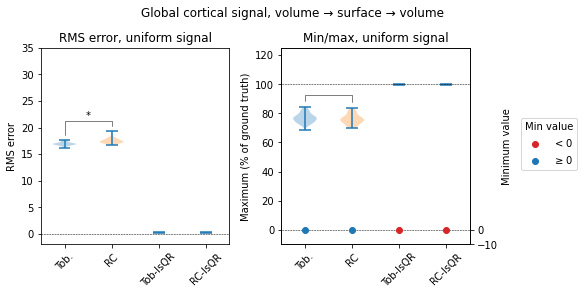

In [11]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(8,4))

sig = 'flat'
exp = 'naive'
ax = axes[0]
data = 100 * vsv.loc[exp,:,sig,:,'rms'].T
ax.set_title('%s, %s' % ('RMS error', SIGNAL_title[sig]))    
plot_format_violins(ax, data)
ax.set_ylim(-2, 35)
ax.set_ylabel("RMS error")
plot_ttest(ax, *data[:2])

ax = axes[1]
data = vsv.loc[exp,:,sig,:,'max'].T
ax.set_title('%s, %s' % ('Min/max', SIGNAL_title[sig]))    
plot_format_violins(ax, data)
ax.plot([0,7], [100,100], 'k--', linewidth=0.5)
ax.set_ylim(YMIN, 125)
ax.set_ylabel("Maximum (% of ground truth)")
plot_ttest(ax, *data[:2])      

ax2 = ax.twinx()
data = vsv.loc[exp,:,sig,:,'min'].mean('sub').T
low = (data < -1e-2)
ax2.scatter(np.flatnonzero(low)+1, data[low], color='tab:red', label=r'$<$0')
ax2.scatter(np.flatnonzero(~low)+1, data[~low], color='tab:blue', label=r'$\geq$0')
ax2.set_ylim(YMIN,125)
ax2.set_ylabel("Minimum value")
ax2.set_yticks([YMIN,0])
ax2.legend(title='Min value', loc=(1.27, 0.38))


fig.suptitle('Global cortical signal, volume \u2192 surface \u2192 volume')
plt.savefig('figures/vsv_cortical_small.png', dpi=250)
plt.show()

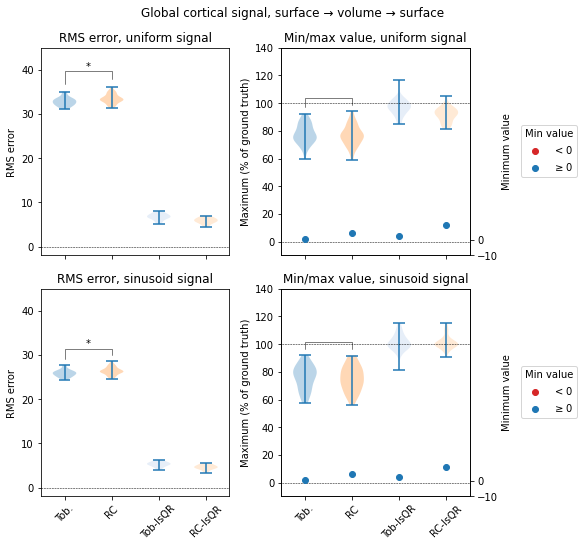

In [12]:
fig, axes = plt.subplots(len(EXPERIMENTS), 2, sharex=True, constrained_layout=True, figsize=(8,7.5))
for sigidx,sig in enumerate(SIGNALS):
        
        ax = axes[sigidx,0]
        data = 100 * svs.loc['naive',:,sig,:,'rms'].T
        ax.set_title('%s, %s' % ('RMS error', SIGNAL_title[sig]))    
        plot_format_violins(ax, data)
        ax.set_ylim(-2, 45)
        ax.set_ylabel("RMS error")
        plot_ttest(ax, *data[:2])
        
        ax = axes[sigidx,1]
        data = svs.loc['naive',:,sig,:,'max'].T
        ax.set_title('%s, %s' % ('Min/max value', SIGNAL_title[sig]))    
        plot_format_violins(ax, data)
        ax.plot([0,7], [100,100], 'k--', linewidth=0.5)
        ax.set_ylim(YMIN, 140)
        ax.set_ylabel("Maximum (% of ground truth)")
        plot_ttest(ax, *data[:2])      
        
        ax2 = ax.twinx()
        data = svs.loc['naive',:,sig,:,'min'].mean('sub').T
        low = (data < -1e-2)
        ax2.scatter(np.flatnonzero(low)+1, data[low], color='tab:red', label=r'$<$0')
        ax2.scatter(np.flatnonzero(~low)+1, data[~low], color='tab:blue', label=r'$\geq$0')
        ax2.set_ylim(YMIN,125)
        ax2.set_ylabel("Minimum value")
        ax2.set_yticks([YMIN,0])
        ax2.legend(title='Min value', loc=(1.27, 0.38))


fig.suptitle('Global cortical signal, surface \u2192 volume \u2192 surface')
plt.savefig('figures/svs_cortical.png', dpi=250)
plt.show()

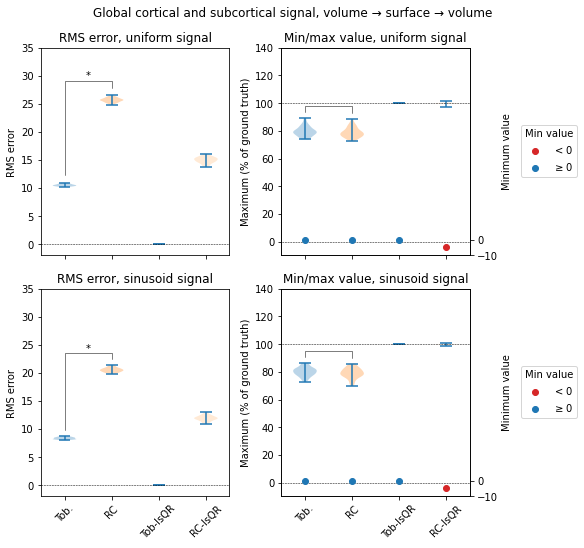

In [13]:
fig, axes = plt.subplots(len(EXPERIMENTS), 2, sharex=True, constrained_layout=True, figsize=(8,7.5))
for sigidx,sig in enumerate(SIGNALS):
        
        ax = axes[sigidx,0]
        data = 100 * vsv.loc['wm_cbf',:,sig,:,'rms'].T
        ax.set_title('%s, %s' % ('RMS error', SIGNAL_title[sig]))    
        plot_format_violins(ax, data)
        ax.set_ylim(-2, 35)
        ax.set_ylabel("RMS error")
        plot_ttest(ax, *data[:2])
        
        ax = axes[sigidx,1]
        data = vsv.loc['wm_cbf',:,sig,:,'max'].T
        ax.set_title('%s, %s' % ('Min/max value', SIGNAL_title[sig]))    
        plot_format_violins(ax, data)
        ax.plot([0,7], [100,100], 'k--', linewidth=0.5)
        ax.set_ylim(YMIN, 140)
        ax.set_ylabel("Maximum (% of ground truth)")
        plot_ttest(ax, *data[:2])      
        
        ax2 = ax.twinx()
        data = vsv.loc['wm_cbf',:,sig,:,'min'].mean('sub').T
        low = (data < -1e-2)
        ax2.scatter(np.flatnonzero(low)+1, data[low], color='tab:red', label=r'$<$0')
        ax2.scatter(np.flatnonzero(~low)+1, data[~low], color='tab:blue', label=r'$\geq$0')
        ax2.set_ylim(YMIN,125)
        ax2.set_ylabel("Minimum value")
        ax2.set_yticks([YMIN,0])
        ax2.legend(title='Min value', loc=(1.27, 0.38))


fig.suptitle('Global cortical and subcortical signal, volume \u2192 surface \u2192 volume')
plt.savefig('figures/vsv_subcortical.png', dpi=250)
plt.show()

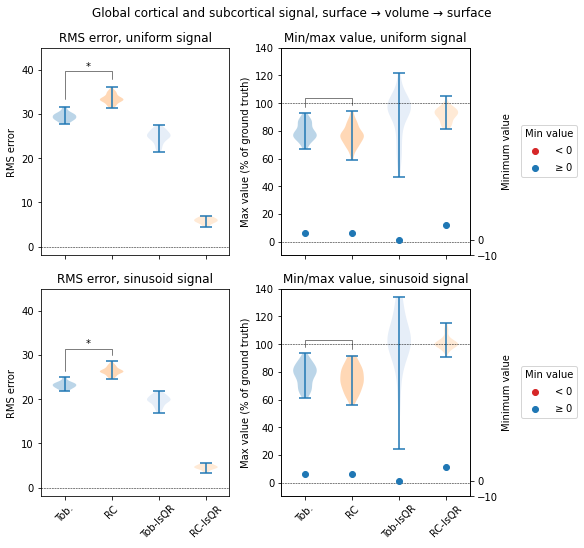

In [14]:
fig, axes = plt.subplots(len(EXPERIMENTS), 2, sharex=True, constrained_layout=True, figsize=(8,7.5))
for sigidx,sig in enumerate(SIGNALS):
        
        ax = axes[sigidx,0]
        data = 100 * svs.loc['wm_cbf',:,sig,:,'rms'].T
        ax.set_title('%s, %s' % ('RMS error', SIGNAL_title[sig]))    
        plot_format_violins(ax, data)
        ax.set_ylim(-2, 45)
        ax.set_ylabel("RMS error")
        plot_ttest(ax, *data[:2])
        
        ax = axes[sigidx,1]
        data = svs.loc['wm_cbf',:,sig,:,'max'].T
        ax.set_title('%s, %s' % ('Min/max value', SIGNAL_title[sig]))    
        plot_format_violins(ax, data)
        ax.plot([0,7], [100,100], 'k--', linewidth=0.5)
        ax.set_ylim(YMIN, 140)
        ax.set_ylabel("Max value (% of ground truth)")
        plot_ttest(ax, *data[:2])      
        
        ax2 = ax.twinx()
        data = svs.loc['wm_cbf',:,sig,:,'min'].mean('sub').T
        low = (data < -1e-2)
        ax2.scatter(np.flatnonzero(low)+1, data[low], color='tab:red', label=r'$<$0')
        ax2.scatter(np.flatnonzero(~low)+1, data[~low], color='tab:blue', label=r'$\geq$0')
        ax2.set_ylim(YMIN,125)
        ax2.set_ylabel("Minimum value")
        ax2.set_yticks([YMIN,0])
        ax2.legend(title='Min value', loc=(1.27, 0.38))


fig.suptitle('Global cortical and subcortical signal, surface \u2192 volume \u2192 surface')
plt.savefig('figures/svs_subcortical.png', dpi=250)
plt.show()

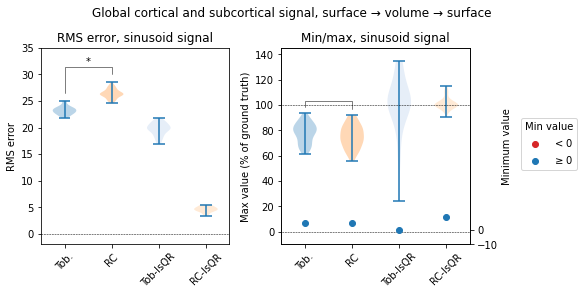

In [15]:
fig, axes = plt.subplots(1, 2, constrained_layout=True, figsize=(8,4))

sig = 'sine'
exp = 'wm_cbf'
ax = axes[0]
data = 100 * svs.loc[exp,:,sig,:,'rms'].T
ax.set_title('%s, %s' % ('RMS error', SIGNAL_title[sig]))    
plot_format_violins(ax, data)
ax.set_ylim(-2, 35)
ax.set_ylabel("RMS error")
plot_ttest(ax, *data[:2])

ax = axes[1]
data = svs.loc[exp,:,sig,:,'max'].T
ax.set_title('%s, %s' % ('Min/max', SIGNAL_title[sig]))    
plot_format_violins(ax, data)
ax.plot([0,7], [100,100], 'k--', linewidth=0.5)
ax.set_ylim(YMIN, 145)
ax.set_ylabel("Max value (% of ground truth)")
plot_ttest(ax, *data[:2])      

ax2 = ax.twinx()
data = svs.loc[exp,:,sig,:,'min'].mean('sub').T
low = (data < -1e-2)
ax2.scatter(np.flatnonzero(low)+1, data[low], color='tab:red', label=r'$<$0')
ax2.scatter(np.flatnonzero(~low)+1, data[~low], color='tab:blue', label=r'$\geq$0')
ax2.set_ylim(YMIN,125)
ax2.set_ylabel("Minimum value")
ax2.set_yticks([YMIN,0])
ax2.legend(title='Min value', loc=(1.27, 0.38))

fig.suptitle('Global cortical and subcortical signal, surface \u2192 volume \u2192 surface')
plt.savefig('figures/svs_subcortical_small.png', dpi=250)
plt.show()